In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [3]:
def display_image(img, cmap=None, alpha=1.0):
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image, cmap=cmap, alpha=alpha)


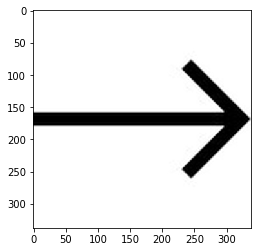

In [46]:
img = cv2.imread('arrow.jpg')
display_image(img)


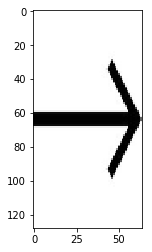

In [47]:
img = cv2.resize(img, (64, 128))
display_image(img)


In [23]:
def display_gradient(gx, gy, mag):
    plt.figure()
    plt.subplot(1, 3, 1)
    display_image(gx)

    plt.subplot(1, 3, 2)
    display_image(gy)

    plt.subplot(1, 3, 3)
    display_image(mag)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


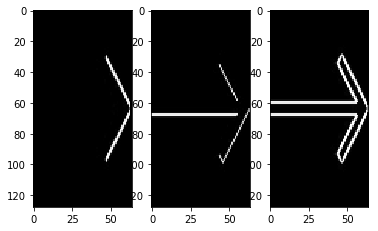

In [48]:
# normalize [0:255] to [0:1]
img = np.float32(img) / 255.0

# Calculate gradient 
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
display_gradient(gx, gy, mag)


In [49]:
h_bin_n = 9
h_bin = np.int32(angle % 180 / (180.0 / h_bin_n))

bin_cells = []
mag_cells = []

cell_x = cell_y = 8

for i in range(0, int(img.shape[0] / cell_y)):
    for j in range(0, int(img.shape[1] / cell_x)):
        bin_cells.append(h_bin[i * cell_y: i * cell_y + cell_y, j * cell_x: j * cell_x + cell_x])
        mag_cells.append(mag[i * cell_y: i * cell_y + cell_y, j * cell_x: j * cell_x + cell_x])


In [50]:
hists = [np.bincount(b.ravel(), m.ravel(), h_bin_n) for b, m in zip(bin_cells, mag_cells)]
hist = np.hstack(hists)


In [51]:
# transform to Hellinger kernel
eps = 1e-7
d_hist = hist / (hist.sum() + eps)
hist /= hist.sum() + eps
hist = np.sqrt(hist)
hist /= np.linalg.norm(hist) + eps


In [28]:
def draw_feature(img, start_x, start_y, block_size, features, bin_n, f_max=1):
    c_x, c_y = int(start_x + block_size / 2), int(start_y + block_size / 2)
    angle_divide = np.pi / bin_n
    for idx, feature in enumerate(features):
        length = feature / f_max * block_size / 2
        angle = idx * angle_divide + angle_divide / 2
        cv2.line(img, (c_x, c_y), (c_x + int(np.cos(angle) * length), c_y + int(np.sin(angle) * -length)), (0, 255, 0),
                 3)
        cv2.line(img, (c_x, c_y), (c_x - int(np.cos(angle) * length), c_y - int(np.sin(angle) * -length)), (0, 255, 0),
                 3)


In [29]:
def display_hog(origin_img, hog_img):
    plt.figure()
    plt.subplot(1, 3, 1)
    display_image(origin_img)

    plt.subplot(1, 3, 2)
    display_image(hog_img)
    
    plt.subplot(1, 3, 3)
    enlarge = cv2.resize(origin_img, (hog_img.shape[1], hog_img.shape[0]))
    display_image(enlarge, alpha=1)
    display_image(hog_img, alpha=0.4)


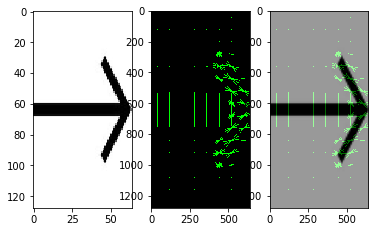

In [52]:
scale = 10
hog_w = img.shape[1] * scale
hog_h = img.shape[0] * scale
block_size = cell_x * scale
hog_img = np.zeros((hog_h, hog_w, 3), np.uint8)
for i in range(0, int(hog_h / block_size)):
    for j in range(0, int(hog_w / block_size)):
        features = hist[
                   (i * int(hog_w / block_size) + j) * h_bin_n:(i * int(hog_w / block_size) + j + 1) * h_bin_n]
        draw_feature(hog_img, j * block_size, i * block_size, block_size, features, h_bin_n, f_max=0.1)

display_hog(img, hog_img)


In [73]:
winSize = (64, 128)
blockSize = (8, 8)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

cv_img = cv2.imread('arrow.jpg')
cv_img = cv2.resize(cv_img, (64, 128))

cv_hist = hog.compute(cv_img).reshape(8, 16, nbins).transpose((1, 0, 2)).flatten()


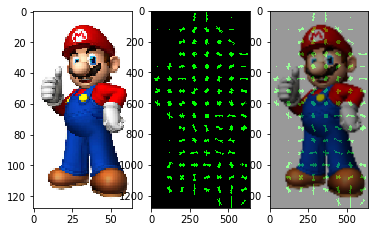

In [ ]:
scale = 10
hog_w = img.shape[1] * scale
hog_h = img.shape[0] * scale
block_size = cell_x * scale
hog_img = np.zeros((hog_h, hog_w, 3), np.uint8)
for i in range(0, int(hog_h / block_size)):
    for j in range(0, int(hog_w / block_size)):
        features = cv_hist[
                   (i * int(hog_w / block_size) + j) * h_bin_n:(i * int(hog_w / block_size) + j + 1) * h_bin_n]
        draw_feature(hog_img, j * block_size, i * block_size, block_size, features, h_bin_n)

display_hog(cv_img, hog_img)


In [66]:
cv_hist.flatten().shape

(1152,)